In [54]:
from pymatgen.analysis.phase_diagram import PhaseDiagram
from pynter.tools.utils import get_object_from_json

# Store chemical potentials with `Reservoirs` class

The goal in this notebook is to define and store the chemical potentials for our phase of interest (NaNbO3). A set of chemical potentials are stored with the `Chempots` class, which behaves like a dictionary, with the element symbol as key and chemical potential as value. Multiple sets of chemical potentials can be stored with the `Reservoirs` class, which also behaves like a dictionary, by assigning to every `Chempots` object a label. <br></br>
In this example, we define sets of chemical potentials based on the boundary of stability of NaNbO3 (A,B,C,D), with an additional point representing a specific value of the oxygen partial pressure ($p_{O_2}$ = 0.2 atm).

Import `PhaseDiagram` object <br></br>

This phase diagram contains the data of othorhombic NaNbO3

In [55]:
phase_diagram = get_object_from_json(PhaseDiagram,'./data/PD_Na-Nb-O_NN_Pbcm.json')
phase_diagram

Na-Nb-O phase diagram
18 stable phases: 
Na, O2, Nb12O29, NaO2, NbO, Na2O2, Na2O, Na3NbO4, NaNb10O18, NaNbO3, NaNbO2, Na5NbO5, NbO2, Nb2O5, NaNb3O8, NaNb13O33, Nb, Na2Nb3O6

In [56]:
from pymatgen.core.composition import Composition
from pynter.phase_diagram.chempots import PDHandler

Plot the stability diagram

<module 'matplotlib.pyplot' from '/nfshome/villa/miniconda3/envs/recent/lib/python3.11/site-packages/matplotlib/pyplot.py'>

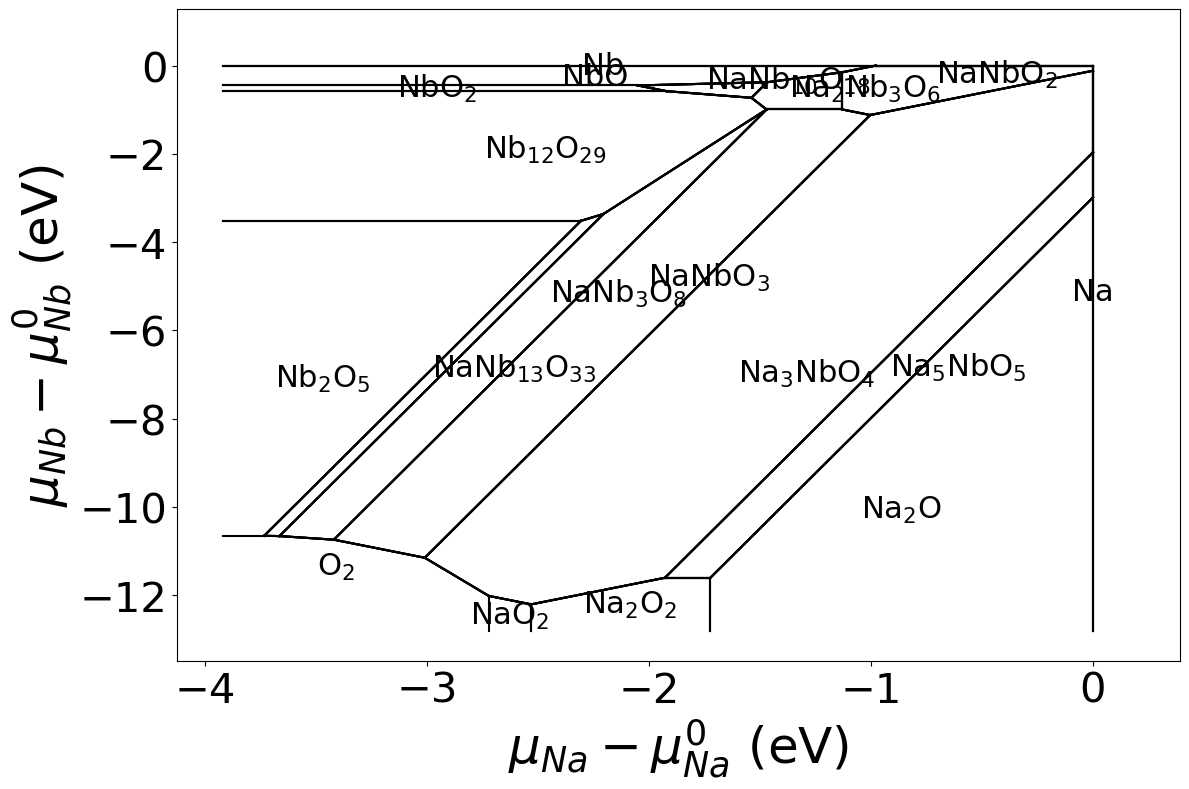

In [57]:
pdhandler = PDHandler(phase_diagram)
pdhandler.get_stability_diagram(elements=['Na','Nb'])

Get chempots in the boundary region and assign labels, create `Reservoirs` object. <br></br>
The chemical potentials can be defined with their absolute value, or with the value referenced to the elmental phase: $$\Delta \mu_{el} = \mu_{el} - \mu^{ref}_{el} $$
The class can handle the conversions, as long as the reference elemental chemical potentials are defined in the `mu_refs` attribute. This can be done manually, or automatically by including the `PhaseDiagram` object in the inputs of the `Reservoirs` class. Lastly, the `are_chempots_delta` argument is necessary to know in which directions the conversions are needed. Keep in mind that for defect calculations the absolute values are needed.

In [58]:
all_chempots = pdhandler.get_all_boundaries_chempots(Composition('NaNbO3'))

In [59]:
all_chempots

{'Na2Nb3O6-NaNbO3-NaNbO2': {'Na': -2.442336834999983, 'Nb': -11.095989200000028, 'O': -8.961561789999994},
 'NaNb3O8-Na2Nb3O6-NaNbO3': {'Na': -2.782759147, 'Nb': -11.09598920000002, 'O': -8.84808768599999},
 'NaNb3O8-NaNbO3-O2': {'Na': -4.732825255624995, 'Nb': -20.846319743124997, 'O': -4.94795546875},
 'Na3NbO4-NaNbO3-O2': {'Na': -4.322852721875002, 'Nb': -21.256292276874994, 'O': -4.94795546875},
 'Na3NbO4-NaNbO3-NaNbO2': {'Na': -2.3160495612499994, 'Nb': -11.22227647375, 'O': -8.96156179}}

In [60]:
from pynter.phase_diagram.chempots import Chempots, Reservoirs

reservoirs_dict = {}

reservoirs_dict['A'] = all_chempots['NaNb3O8-Na2Nb3O6-NaNbO3']
reservoirs_dict['B'] = all_chempots['Na3NbO4-NaNbO3-NaNbO2']
reservoirs_dict['C'] = all_chempots['Na3NbO4-NaNbO3-O2']
reservoirs_dict['D'] = all_chempots['NaNb3O8-NaNbO3-O2']

reservoirs = Reservoirs(res_dict=reservoirs_dict,phase_diagram=phase_diagram,are_chempots_delta=False)
reservoirs.get_dataframe()

,Na,Nb,O
A,-2.782759,-11.095989,-8.848088
B,-2.316050,-11.222276,-8.961562
C,-4.322853,-21.256292,-4.947955
D,-4.732825,-20.846320,-4.947955


Get chempots at atmospheric pressure

In [61]:
from pynter.phase_diagram.thermodynamics import OxygenPressure
import numpy as np

mu_O_referenced = OxygenPressure().get_oxygen_chempot_from_pO2(temperature=1633,partial_pressure=0.2)
chempots_ambient_pressure = {}

boundaries = pdhandler.get_phase_boundaries_chempots(Composition('NaNbO3'),{'O':mu_O_referenced})
for element in boundaries[list(boundaries.keys())[0]]:
    value = np.mean([v[element] for v in boundaries.values()]).item()
    chempots_ambient_pressure[element] = value

chempots_ambient_pressure = Chempots(chempots_ambient_pressure).get_absolute(reservoirs.mu_refs)

reservoirs.res_dict['X'] = chempots_ambient_pressure
reservoirs.get_dataframe()

,Na,Nb,O
A,-2.782759,-11.095989,-8.848088
B,-2.316050,-11.222276,-8.961562
C,-4.322853,-21.256292,-4.947955
D,-4.732825,-20.846320,-4.947955
X,-3.567127,-16.247745,-6.869380


# Visualize stability diagram and reservoirs

The `PDPlotterAdder` class can be used to add the heatmap and the reservoirs points to the plot. The heatmap shows the chemical potential of oxygen, which is determined by the chempot of the other two elements. 

<module 'matplotlib.pyplot' from '/nfshome/villa/miniconda3/envs/recent/lib/python3.11/site-packages/matplotlib/pyplot.py'>

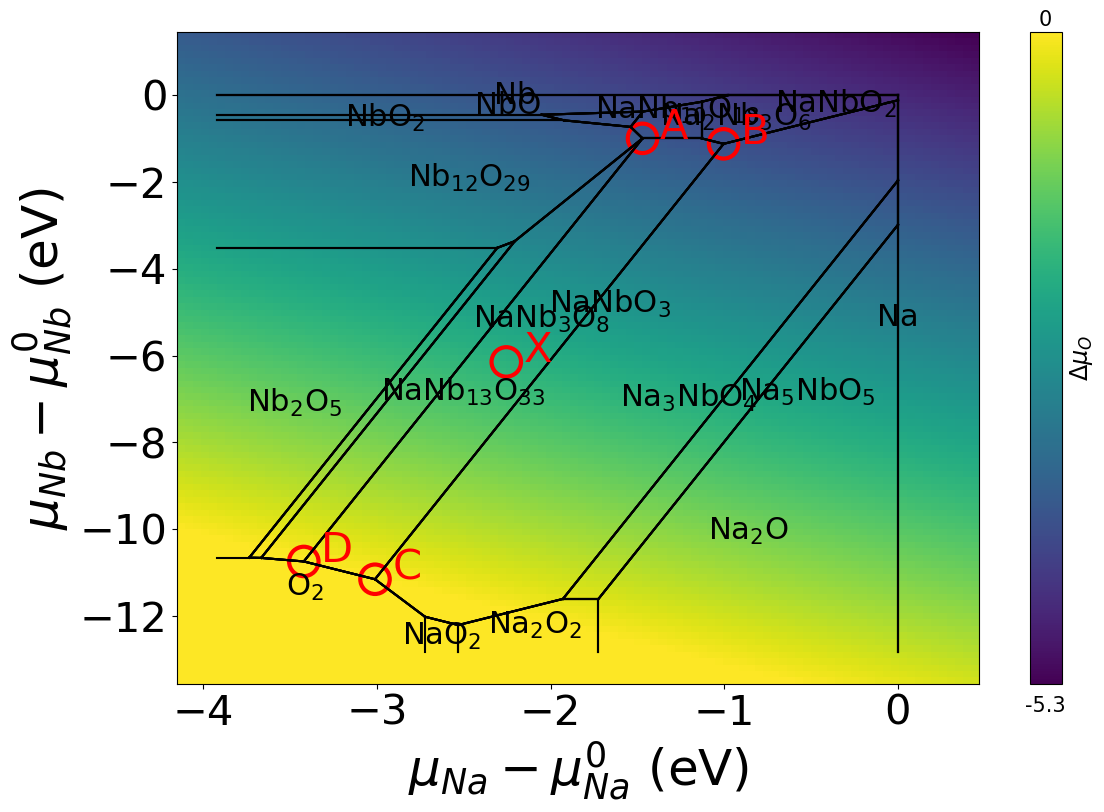

In [62]:
from pynter.phase_diagram.plotter import PDPlotterAdder
import matplotlib.pyplot as plt

plotter = PDPlotterAdder(phase_diagram)

pdhandler.get_stability_diagram(['Na','Nb'])

plotter.add_heatmap(Composition('NaNbO3'),elements=['Na','Nb'])

reservoirs_referenced = reservoirs.copy()
reservoirs_referenced.set_to_referenced()
plotter.add_reservoirs(reservoirs=reservoirs_referenced,elements=['Na','Nb'],edgecolor='red',label_color='red')

# Export `Reservoirs` to `json`

In [63]:
reservoirs.to_json('./data/reservoirs.json')

# Define chemical potentials for extrinsic elements

In [64]:
pdh_Ca = PDHandler(get_object_from_json(PhaseDiagram,'./data/PD_Ca-Sn-O.json'))
pdh_Sr = PDHandler(get_object_from_json(PhaseDiagram,'./data/PD_Sr-Sn-O.json'))

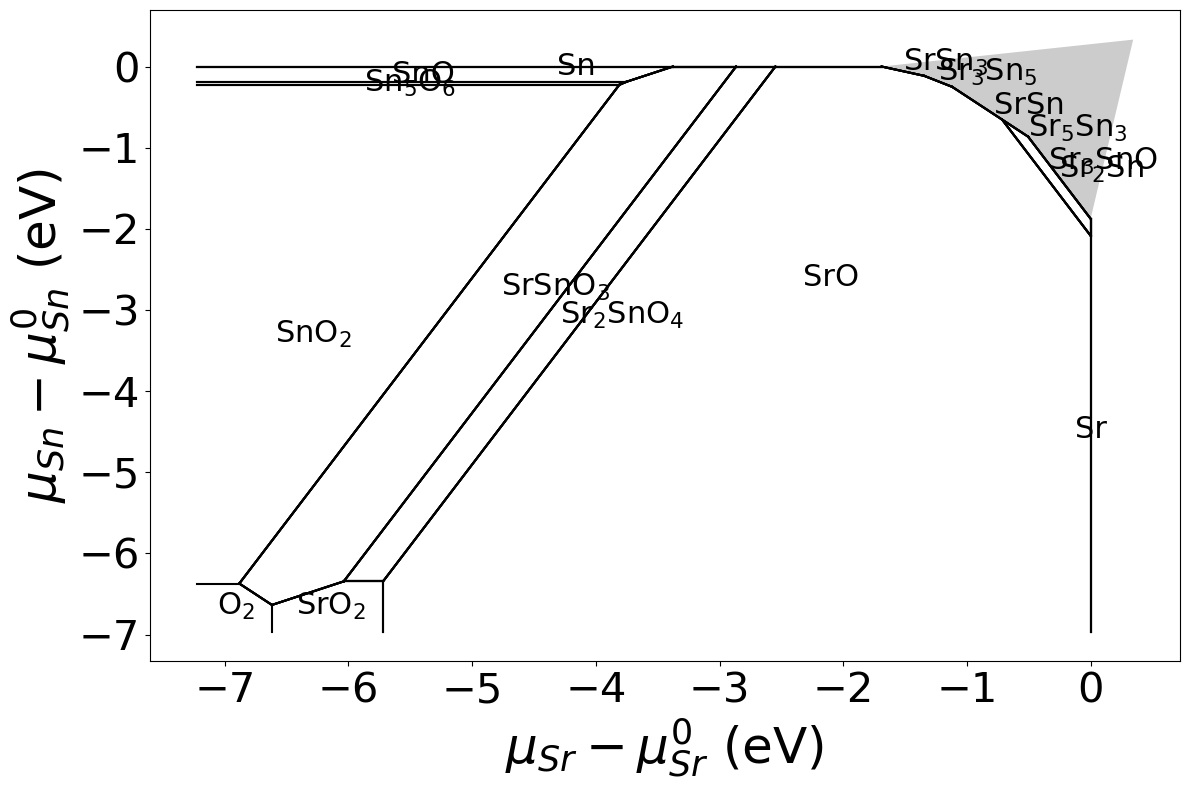

In [65]:
pdh_Sr.get_stability_diagram(elements=['Sr','Sn']);

In [66]:
pdh_Sr.mu_refs

{'Sr': -1.6894812533333334, 'Sn': -3.99229498, 'O': -4.94795546875}

## Choose chemical potentials in oxygen poor and oxygen rich regions

In [67]:
mu_Sr_O_poor = -3.5 
mu_Sr_O_rich = -6.5
mu_Sn_O_poor = 0
mu_Sn_O_rich = -6

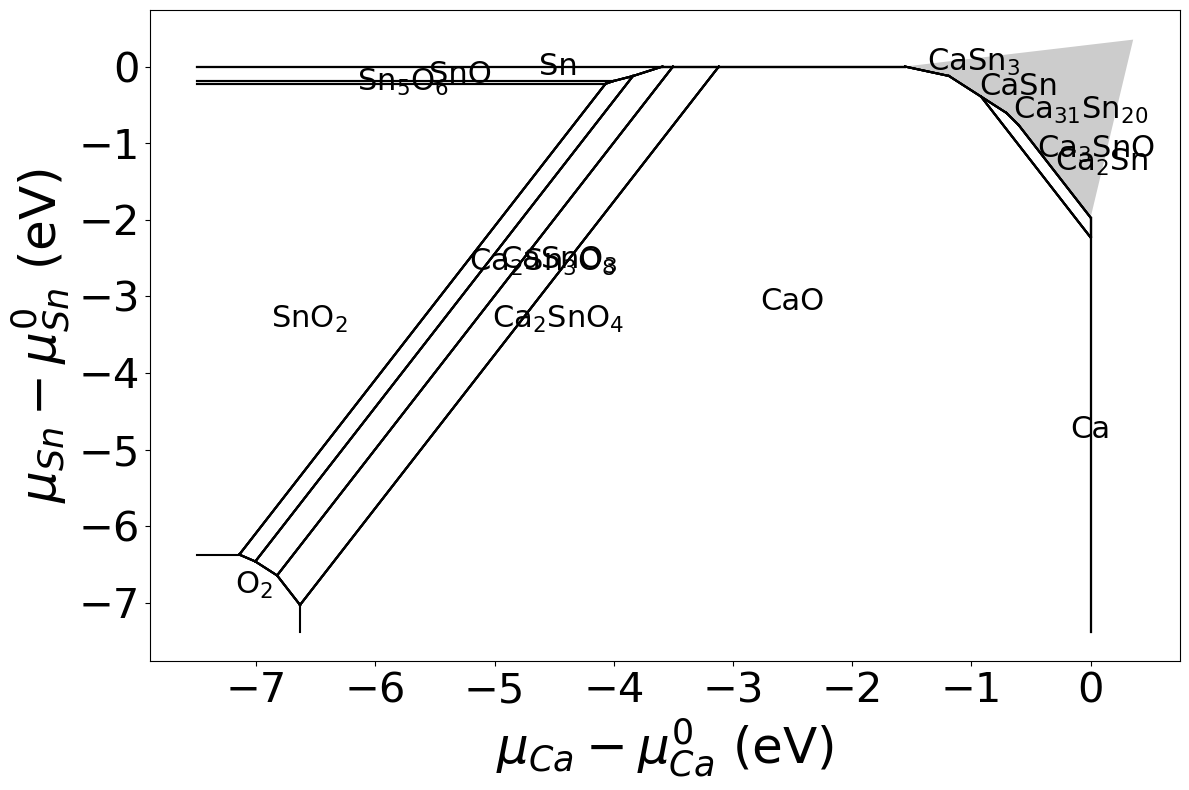

In [68]:
pdh_Ca.get_stability_diagram(elements=['Ca','Sn']);

In [69]:
mu_Ca_O_poor = -4
mu_Ca_O_rich = -7

## Assign chempots to O-poor and O-rich regions of main phase diagram (NaNbO3)

In [70]:
reservoirs.set_to_referenced()
reservoirs_extrinsic = reservoirs.copy()
for r,mu in reservoirs_extrinsic.items():
    if r in ['A','B']:
        reservoirs_extrinsic[r]['Sr'] = mu_Sr_O_poor 
        reservoirs_extrinsic[r]['Sn'] = mu_Sn_O_poor
        reservoirs_extrinsic[r]['Ca'] = mu_Ca_O_poor
    if r in ['C','D']:
        reservoirs_extrinsic[r]['Sr'] = mu_Sr_O_rich
        reservoirs_extrinsic[r]['Sn'] = mu_Sn_O_rich
        reservoirs_extrinsic[r]['Ca'] = mu_Ca_O_rich

In [71]:
# add po2 = 0.2 atm point
reservoirs_extrinsic['X']['Sr'] = -5.79
reservoirs_extrinsic['X']['Sn'] = -4.19
reservoirs_extrinsic['X']['Ca'] = -5.92

In [75]:
# update reference chempots with new elements
reservoirs_extrinsic.mu_refs['Sr'] = pdh_Sr.mu_refs['Sr']
reservoirs_extrinsic.mu_refs['Sn'] = pdh_Sr.mu_refs['Sn']
reservoirs_extrinsic.mu_refs['Ca'] = pdh_Ca.mu_refs['Ca']
reservoirs_extrinsic.mu_refs

{'Na': -1.312223005, 'Nb': -10.10130504, 'O': -4.94795546875, 'Sr': -1.6894812533333334, 'Sn': -3.99229498, 'Ca': -1.999462735}

In [76]:
reservoirs_extrinsic.get_dataframe(ndecimals=2)

,Na,Nb,O,Sr,Sn,Ca
A,-1.47,-0.99,-3.90,-3.50,0.00,-4.00
B,-1.00,-1.12,-4.01,-3.50,0.00,-4.00
C,-3.01,-11.15,0.00,-6.50,-6.00,-7.00
D,-3.42,-10.75,0.00,-6.50,-6.00,-7.00
X,-2.25,-6.15,-1.92,-5.79,-4.19,-5.92


In [77]:
reservoirs_extrinsic.set_to_absolute()

In [78]:
reservoirs_extrinsic.to_json('./data/reservoirs_extrinsic.json')